In [43]:
#Imports TODO: Add a install.py script to check if all dependencies are installed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.io.wavfile as wf
import scipy.signal
from pprint import pprint

In [111]:
class Signal:
    
    def __init__(self, path, mode='dev'):
        file = wf.read(path)
        self.Fs = file[0]
        self.s = file[1]
        self.N = self.s.shape[0]
        self.T = self.N/self.Fs
        self.t = np.arange(0,self.T,1/self.Fs)
        self.mode = mode
        
    
    def plot_signal(self, show = True, invert=False):
        # Show the sound on a plot
        if show: plt.figure(figsize=(20,10))
        if invert: plt.plot(self.s, self.t)
        if not invert: 
            plt.plot(self.t,self.s)
            plt.xlim(0,36)
        if show:
            plt.show()
            
    def plot_fft(self, show = True, invert=True):
        # Show the sound on a plot
        if show: plt.figure(figsize=(20,10))
        if invert:
            plt.plot(abs(np.fft.rfft(self.s)), np.fft.rfftfreq(len(self.s), 1/self.Fs))
            plt.ylim(0,22000)
            plt.gca().invert_xaxis()
        if not invert: 
            plt.plot(np.fft.rfftfreq(len(self.s), 1/self.Fs),np.fft.rfft(self.s))
            plt.xlim(0,36)
        if show:
            plt.show()
    
    def set_window(self,window):
        if type(window) == type(lambda t: t):
            self.window = window
        else:
            raise TypeError('Invalid type of window, must be a function. eg. lambda x: np.ones(x)')
    
    def find_cut_off(self, W, ratio=0.0001):
        summed = np.sum(W, axis=1)
        summed /= np.linalg.norm(summed)
        max_val = max(summed)
        summed /= max_val
        summed[summed < ratio] = 0
        return np.where(summed == 0)[0][0]
    
    def calc_spectogram(self, n, t_low=0, t_high=-1):
        # cut up the data into n smaller pieces

        # setup the array size
        n = 1000
        while self.N%n != 0: #Find the first integer division
            n -= 1

        l_probe = int(self.N/n)
        t_probe = l_probe/self.Fs
        if (self.mode == 'dev'): print('Length of probe: {}, {:.3f}s \nNumber of probes: {}'.format(l_probe, t_probe, n))

        a_minor = self.s.reshape(n, int(self.N/n))
        t_minor = np.arange(0, int(self.N/n)/self.Fs, 1/self.Fs)
        
        #Ok so now we have an array of a cut up signal, we need to window each signal and find the FFT of all trials
        w = self.window(l_probe)
        w_minor = a_minor * w
        self.W_minor = abs(np.fft.rfft(w_minor).astype('float')).T
        self.F_minor = np.fft.rfftfreq(len(w_minor[0]), 1/self.Fs)
    
    def plot_spectogram(self, N_wsp=1000, show = True, ratio = 0.0001, t_start=0, t_end=1): # TODO time window, extra diagrams, left f(w) bottom f(t)
        try:
            if self.W_minor == None or self.F_minor == None:
                pass
        except:
            self.calc_spectogram(N_wsp)
        print(self.W_minor.shape)
        cutoff = self.find_cut_off(self.W_minor, ratio)
        cutoff = -1
        plt.imshow(self.W_minor[:cutoff], extent=[ 0, self.t[-1], 0, self.F_minor[cutoff] ], aspect=self.t[-1]/self.F_minor[cutoff], origin='lower', cmap="hot")
        # plt.colorbar()
        if show:
            plt.show()
        

Length of probe: 1620, 0.037s 
Number of probes: 980
(811, 980)


/home/pawel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:68: ComplexWarning: Casting complex values to real discards the imaginary part


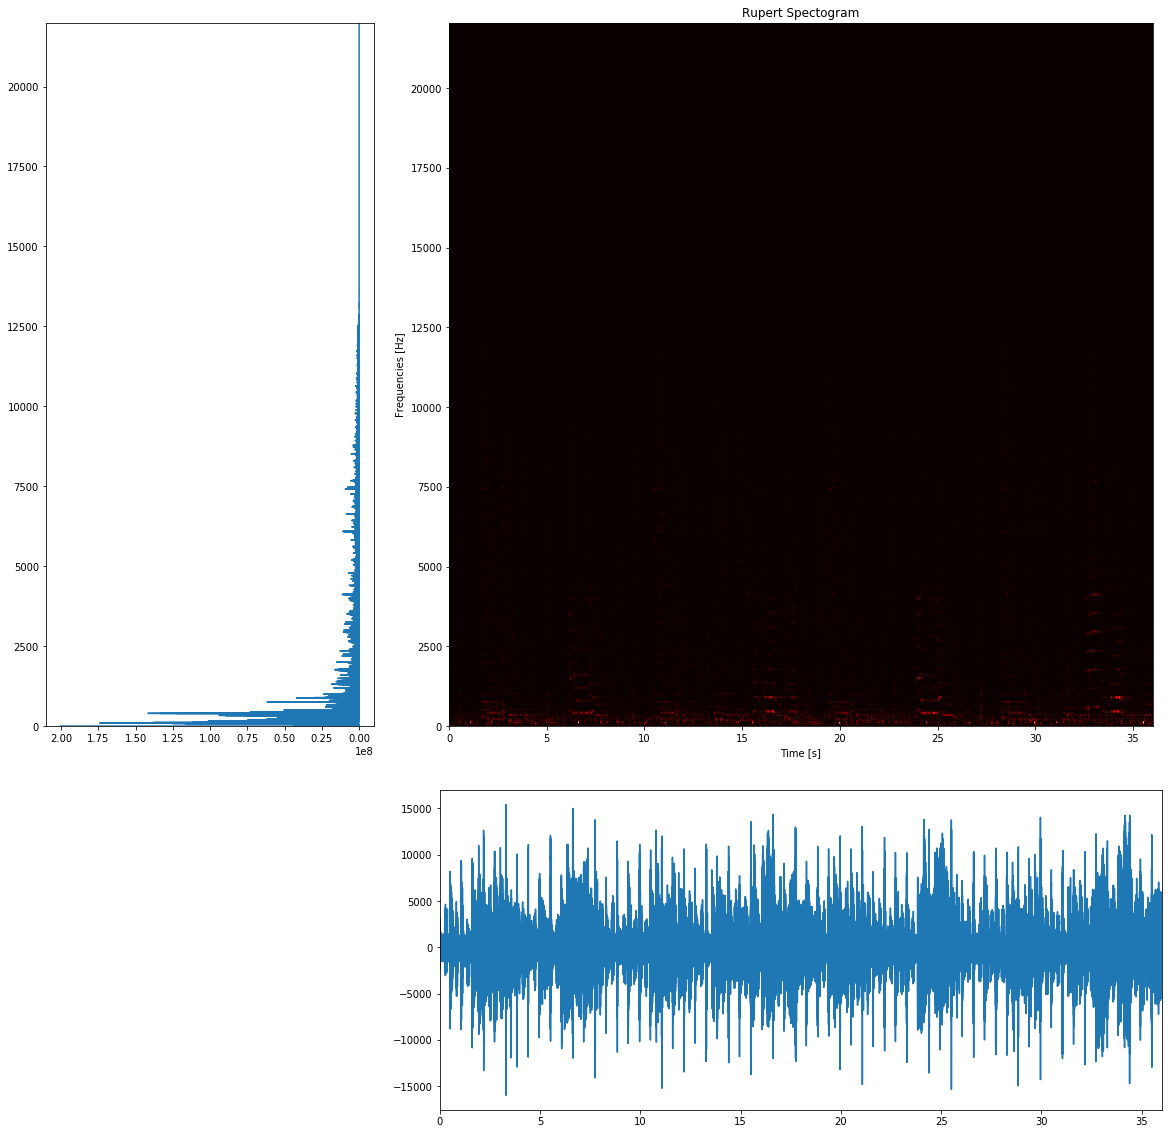

In [114]:
plt.figure(figsize=((20,20)))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])
gs.update(left=0.05, right=0.95, bottom=0.1, wspace=0.5)

rupert = Signal('./data/candy.wav')

# plt.subplot(gs[0])
plt.subplot2grid((3, 3), (0, 0), rowspan=2)
rupert.plot_fft(show = False, invert=True)

# plt.subplot(gs[1])
plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=2)
rupert.set_window(lambda n: scipy.signal.blackman(n))
plt.title('Rupert Spectogram')
plt.ylabel('Frequencies [Hz]')
plt.xlabel('Time [s]')
rupert.plot_spectogram(show=False, N_wsp=30)

# plt.subplot(gs[3])
plt.subplot2grid((3, 3), (2, 1), colspan=2)
rupert.plot_signal(show = False)

plt.show()

# plt.figure(figsize=((20,40)))

# gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])

# plt.subplot(gs[1])
# candy = Signal('./data/candy.wav')
# candy.set_window(lambda n: scipy.signal.blackman(n))
# plt.title('Candy Spectogram')
# plt.ylabel('Frequencies [Hz]')
# plt.xlabel('Time [s]')
# candy.plot_spectogram(show=False, N_wsp=30, ratio=0.03)

# plt.show()

In [113]:
# 